## 1.Streszczenie raportu
Raport pochodzi ze strony Kaggle.com, dane zostały wyodrębnione przez użytkownika Neel Kamal i pochodzą ze strony MagicBricks.com (zajmującej się handlem nieruchomościami w Delhi). https://www.kaggle.com/neelkamal692/delhi-house-price-prediction

In [92]:
library('ggplot2')
library('magrittr')
library('dplyr')
library('e1071') 
library('caret')
library ('DescTools')

In [2]:
data <- read.csv('magicbricks.csv')

## 2.Opis danych
### Nasze dane składają się z 1259 rekordów
 Area - powierzchnia budynku wyrażona w stopach kwadratowych<br>
 BHK - ilość sypialni wraz z 1 korytarzem i 1 kuchnią<br>
 Bathroom - ilość łazienek<br>
 Furnishing - stan umeblowania, w wyczyszczonych danych<br>
 Locality - dzielnica delhi, nie będzie nam potrzebna<br>
 Parking - ilość dostępnych miejsc parkingowych<br>
 Price - cena wyrażona w rupiach indyjskich<br>
 Transaction - mówi nam czy budynek jest nowy czy jest odsprzedawany<br>
 Type - mówi nam czy jest to mieszkanie czy budynek<br>
 Per_Sqft - cena za jedną stopę kwadratową
 
 Głównym celem projektu jest zbadanie wpływu poszczególnych parametrów mieszkania na jego cenę.


## 3 Analiza danych
### 3.0 Przygotowanie i czyszczenie danych

Z danych usuwamy mieszkania o powierzchni większej niż 200m^2 gdyż były to pojedyncze odstające wartości,<br> 
oraz odstające wartości dla ceny mieszkań pozostawiając wartosci mieszczace się jedynie w przedziale od<br> 
Q1-1.5IQR do Q3+1.5IQR.<br> 
Przewalutowujemy cenę na złotówki a stopy kwadratowe na metry kwadratowe.<br> 
Usunięte zostały także niepotrzebne do analizy kolumny oraz puste wiersze.<br> 
Po czyszczeniu danych pozostało 843 gotowe do analizy rekordy.<br> 
Nazwa kolumny Per_Sqft zostala zmieniona na Per_SqM zgodnie z wartosciami.<br> 

In [3]:
clean <- data
clean <- mutate(clean,Price=Price*0.054,Area=Area*0.0929,Per_Sqft = Price/Area)
clean <- na.omit(clean)
clean <- subset(clean,select = -c(Furnishing,Locality,Status,Transaction,Type)) 
clean <- rename(clean,Per_SqM=Per_Sqft)

Q1 <- quantile(clean$Price)[1]
Q3 <- quantile(clean$Price)[3]
IQR <-Q3-Q1
clean <- subset(clean,Price<Q3+1.5*IQR)
clean <- subset(clean,Price>Q1-1.5*IQR)
clean <- subset(clean,Area<200) # własność zauważona na podstawie wykresu Box Plot
clean <- subset(clean,BHK<5) # własność zauważona na podstawie wykresu Box Plot - 3 odstające wartości
head(clean)

,Area,BHK,Bathroom,Parking,Price,Per_SqM
,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>
1,74.320,3,2,1,351000,4722.820
2,69.675,2,2,1,270000,3875.135
3,88.255,2,2,1,837000,9483.882
4,55.740,2,2,1,226800,4068.891
5,60.385,2,2,1,334800,5544.423
6,120.770,4,3,1,837000,6930.529


### 3.1 Wydobywanie podstawowych informacji z danych
### 3.1.1 Area

#### Histogram

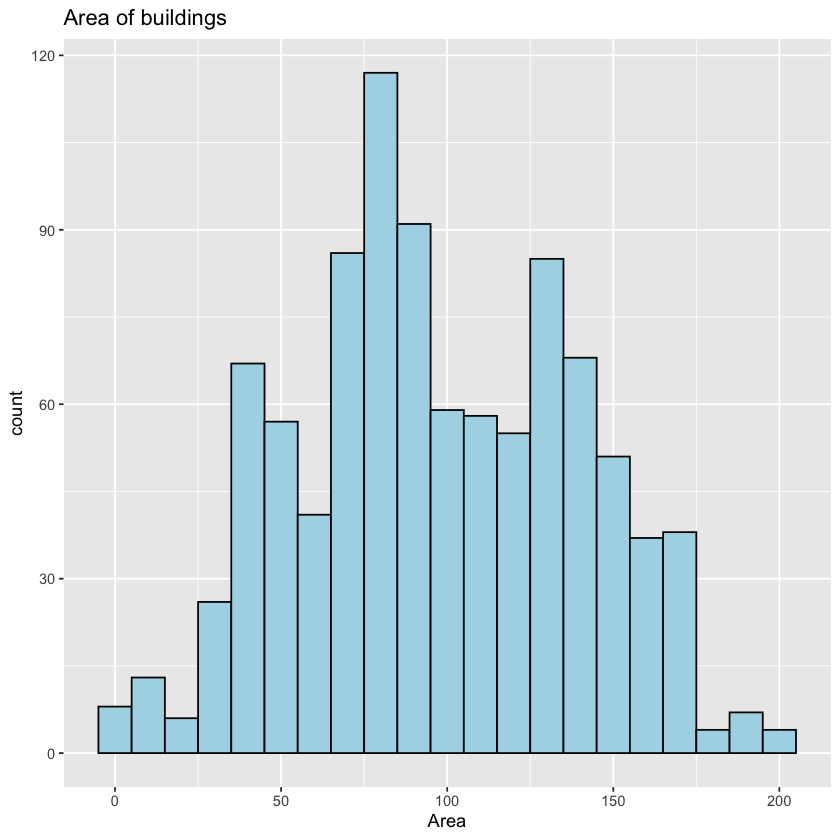

In [4]:
ggplot(clean["Area"], aes(x = Area)) + 
  geom_histogram(fill = "lightblue", color = "black",binwidth=10) + 
  ggtitle("Area of buildings")

Z naszego histogramu można zauważyć, że wartości układają się nieznacznie bardziej po lewej<br> stronie osi symetrii, co może wskazywać na rozkład prawo<br> skośny. Wykres nie wygląda na obiecujący dla dystrybucji normalnej, ponieważ jego środkowe wartości są zbyt odstające.

#### Box Plot

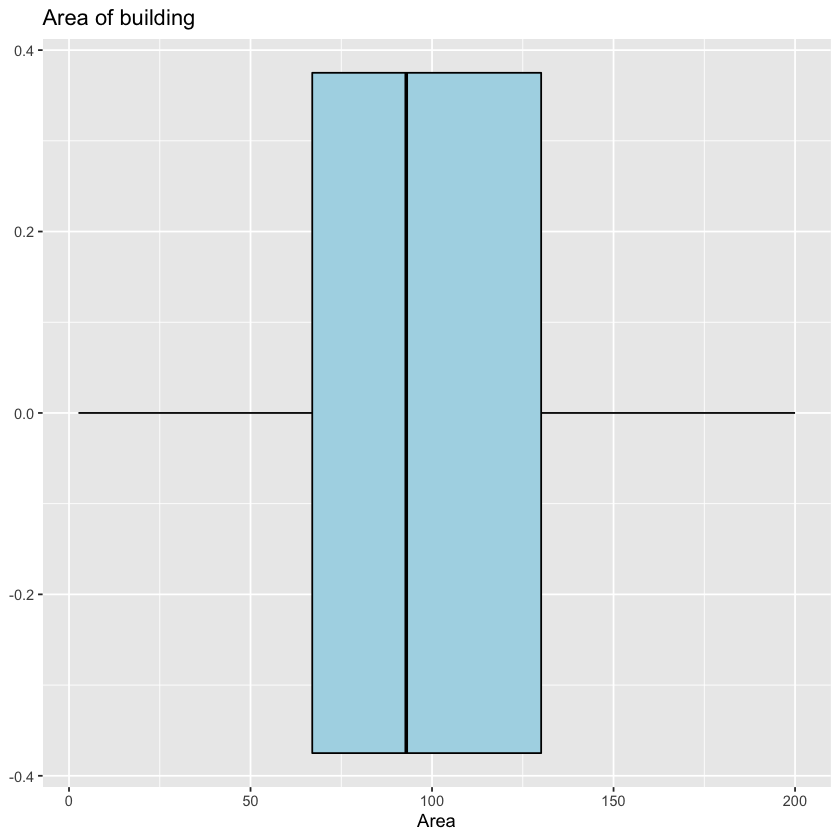

In [5]:
ggplot(clean["Area"], aes(x = Area)) + 
  geom_boxplot(fill = "lightblue", color = "black") + 
  ggtitle("Area of building")

Z naszego wykresu typu box-plot możemy zauważyć, że udało nam się wyeliminować wartości odstające.

#### Q-Q Plot

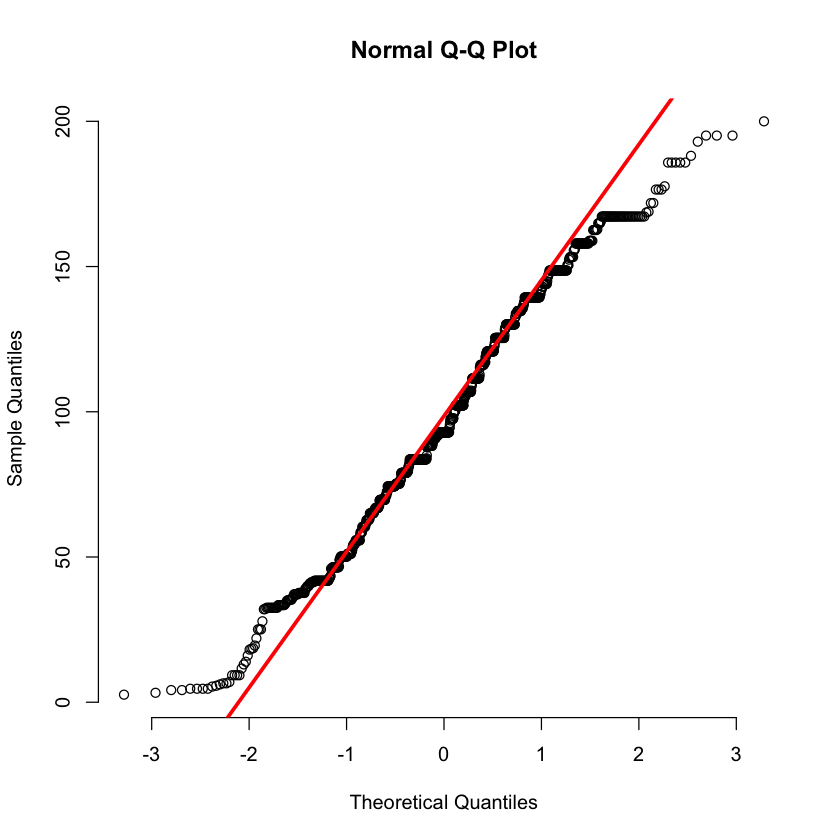

In [6]:
qqnorm(clean$Area, pch = 1, col = "black", frame = FALSE)
qqline(clean$Area, col = "red", lwd = 3)

##### Wartość średnia 

In [7]:
round(mean(clean$Area),digits=4)

[1] 97.0096

##### Wariancja

In [8]:
round(var(clean$Area),digits=4)

[1] 1704.103

##### Odchylenie standardowe

In [9]:
round(sd(clean$Area),digits=4)

[1] 41.2808

##### Mediana 

In [10]:
round(median(clean$Area),digits=4)

[1] 92.9

##### Zakres wartości

In [11]:
range(clean$Area)

[1]   2.6012 199.9933

##### Kwantyle

In [12]:
quantile(clean$Area)

0%       25%       50%       75%      100% 
  2.60120  67.00412  92.90000 130.06000 199.99326

##### Skośność

In [13]:
skewness(clean$Area)

[1] 0.01683815

Wartość skewness jest większa od zera co oznacza, że nasze dane mają rozkład prawo-skośny.<br>  Potwierdza to także nasz histgram na którym widać, że większa część danch znajduje się po prawej stronie.<br>  Ponadto wartość średnia jest większa od mediany co również na to wskazuje.

#### Wyostrzenie

In [14]:
kurtosis(clean$Area)

[1] -0.71461

Rozkład jest platykurtyczny, inaczej spłaszczony.

##### Test Rozkładu
Do określenia czy dane pochodzą z rozkładu normalnego skorzystamy z testu Shapiro-Wlk.<br>  Wyjściowa hipotezą jest, że dane należą do rozkładu normalnego. Dokładność wykonywanego testu jest równa 95%.<br>  Test Shapiro-Wilka'a jest najlepszy dla małych ilości danych i jest uznawany za "najsilniejszy" z dostępnych testów możliwych do zastosowania.

In [15]:
shapiro.test(clean$Area)


	Shapiro-Wilk normality test

data:  clean$Area
W = 0.98615, p-value = 5.418e-08


P-value dla naszej zmiennej jest mniejsze od 0.05 co odrzuca wstępną hipotezę.<br>  Zarówno poprzez wykres QQ-plot oraz wykonany test możemy zauważyć,<br>  że dane nie pochodzą z rozkładu normalnego, pomimo częściowo dobrze układającego się wykresu.

#### Przedział ufności średniej (95%)

In [16]:
size <- nrow(clean["Area"])
sd <- sd(clean$Area)
round(MeanCI(clean$Area, sd = sd, conf.level = 0.95),digits = 4)

mean  lwr.ci  upr.ci 
97.0096 94.4224 99.5967

### 3.1.2 Price

#### Histogram

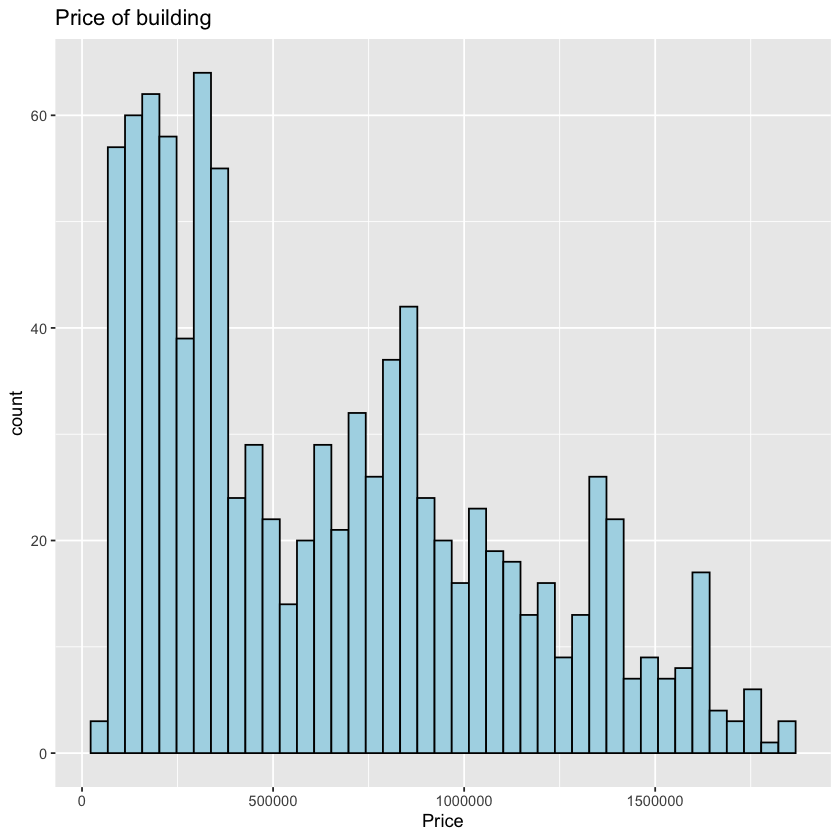

In [17]:
ggplot(clean["Price"], aes(x = Price))+
  geom_histogram(fill = "lightblue", color = "black",binwidth=45000) + 
  ggtitle("Price of building")

Po analizie naszego histogramu śmiało można wyjść z tezą, że rozkład zmiennej Price nie należy do normalnego i jest prawo skośny.

#### Box Plot

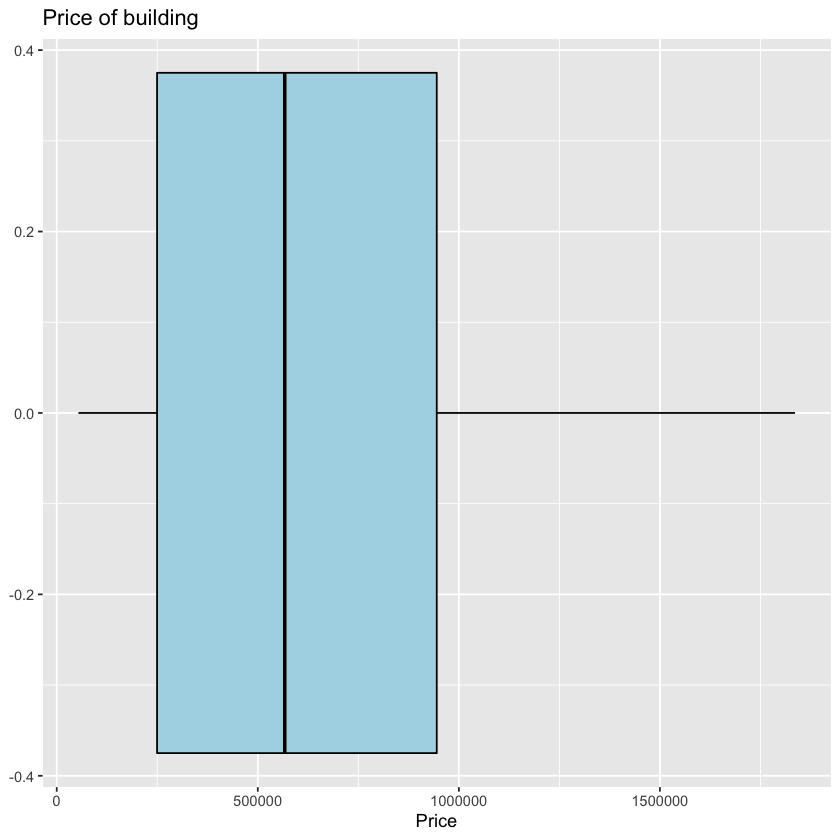

In [18]:
ggplot(clean["Price"], aes(x = Price)) + 
  geom_boxplot(fill = "lightblue", color = "black") + 
  ggtitle("Price of building")

Z wykresu Box Plot dla zmiennej Price można wnioskować, że udało nam się odrzucić wartości odstające.

#### Q-Q Plot

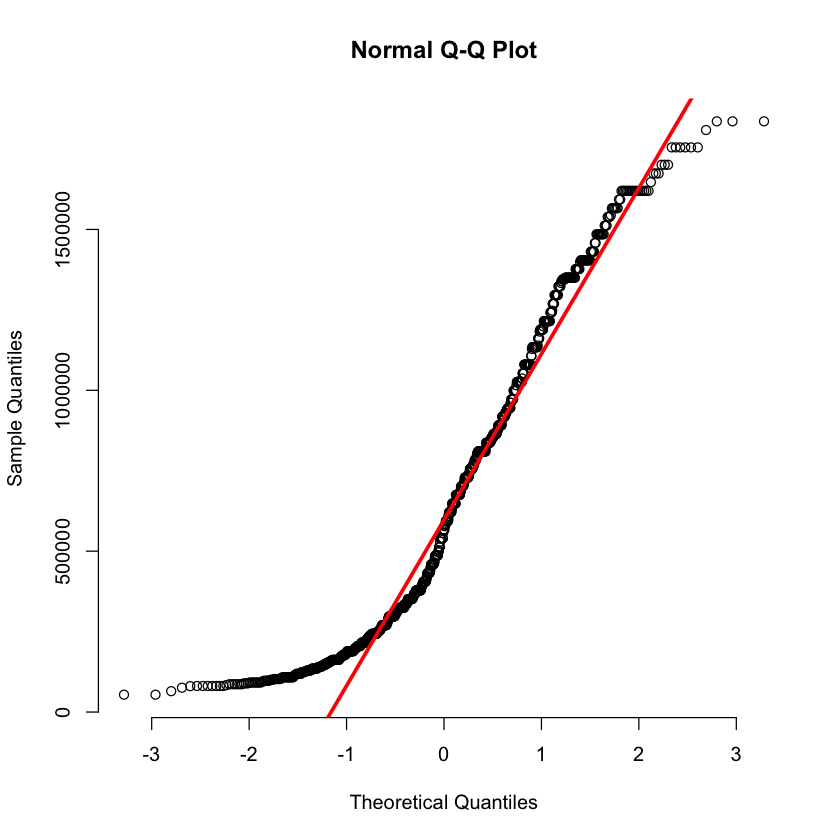

In [19]:
qqnorm(clean$Price, pch = 1, col = "black", frame = FALSE)
qqline(clean$Price, col = "red", lwd = 3)

#### Wartość średnia

In [20]:
round(mean(clean$Price),digits=0)

[1] 650156

#### Wariancja

In [21]:
round(var(clean$Price),digits=0)

[1] 205372812974

#### Odchylenie standardowe

In [22]:
round(sd(clean$Price),digits=0)

[1] 453181

#### Mediana

In [23]:
round(median(clean$Price),digits=0)

[1] 567000

#### Zakres wartości

In [24]:
range(clean$Price)

[1]   54000 1836000

#### Kwantyle

In [25]:
quantile(clean$Price)

0%     25%     50%     75%    100% 
  54000  249480  567000  945000 1836000

#### Skośność

In [26]:
skewness(clean$Price)

[1] 0.6213319

Rozkład naszej zmiennej jest zdecydowanie prawo skośny.

#### Wyostrzenie

In [27]:
kurtosis(clean$Price)

[1] -0.6784557

Rozkład jest platykurtyczny.

#### Test na rozkład normalny stosowany przy poprzedniej zmiennej

In [28]:
shapiro.test(clean$Price)


	Shapiro-Wilk normality test

data:  clean$Price
W = 0.92287, p-value < 2.2e-16


Wykres QQ-plot oraz test wykonany test nie wskazują na to, by dane pochodziły z rozkładu normalnego.

#### Przedział ufności średniej (95%)

In [29]:
size <- nrow(clean["Price"])
sd <- sd(clean$Price)
round(MeanCI(clean$Price, sd = sd, conf.level = 0.95),digits = 0)

mean lwr.ci upr.ci 
650156 621754 678558

### 3.1.3  BHK
Wartości zmiennej pochodzą z rozkładu dyskretnego więc nie będziemy wykonywać<br> testu na rozkład normalny, ani rysowć wykresu Q-Q plot.

#### Histogram

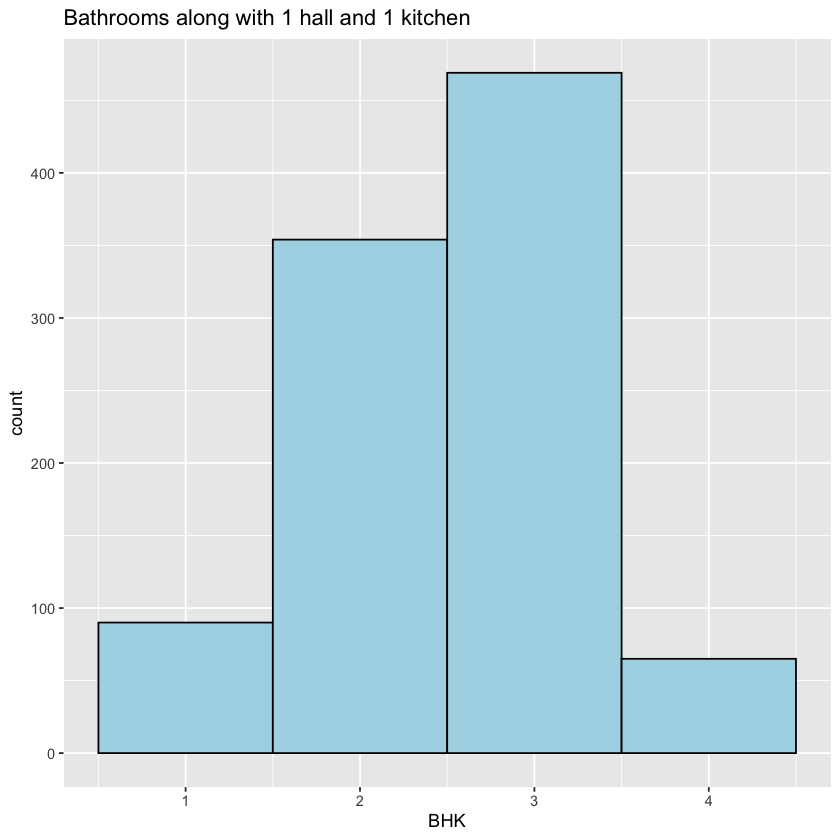

In [30]:
ggplot(clean["BHK"], aes(x = BHK)) + 
  geom_histogram(fill = "lightblue", color = "black",binwidth=1) + 
  ggtitle("Bathrooms along with 1 hall and 1 kitchen")

#### Box Plot

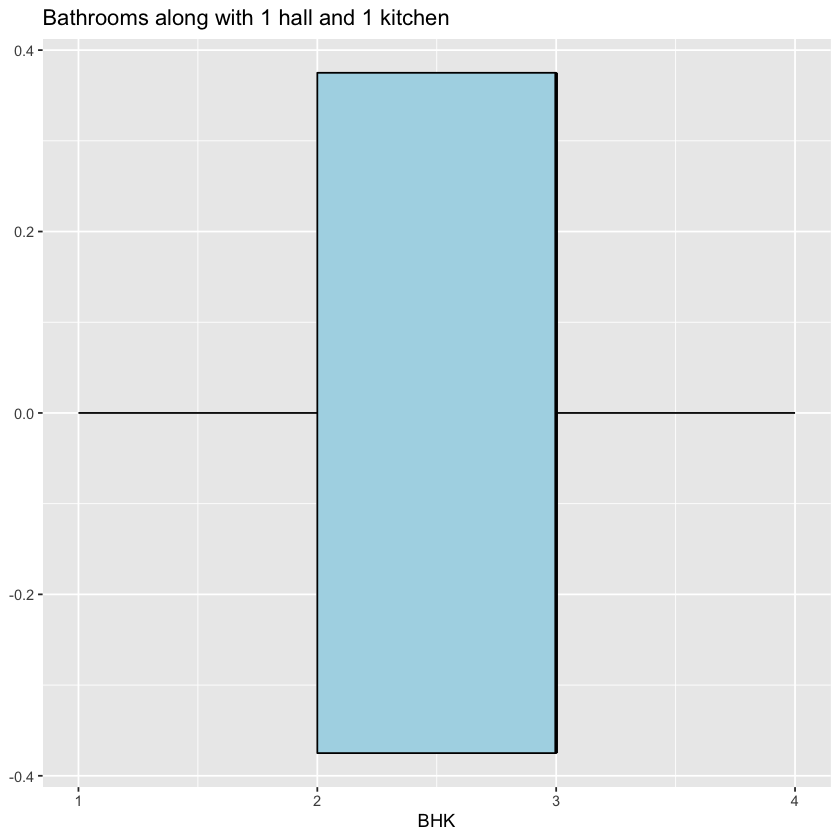

In [31]:
ggplot(clean["BHK"], aes(x = BHK)) + 
  geom_boxplot(fill = "lightblue", color = "black") + 
  ggtitle("Bathrooms along with 1 hall and 1 kitchen")

#### Wartość średnia

In [32]:
round(mean(clean$BHK),digits=4)

[1] 2.5204

#### Wariancja

In [33]:
round(var(clean$BHK),digits=4)

[1] 0.5671

#### Odchylenia standardowe

In [34]:
round(sd(clean$BHK),digits=4)

[1] 0.7531

#### Mediana

In [35]:
round(median(clean$BHK),digits=4)

[1] 3

#### Zakres Wartości

In [36]:
range(clean$BHK)

[1] 1 4

#### Kwantyle

In [37]:
quantile(clean$BHK)

0%  25%  50%  75% 100% 
   1    2    3    3    4

#### Skośność

In [38]:
skewness(clean$BHK)

[1] -0.2489841

Rozkład jest lewo skośny.

#### Wyostrzenie

In [39]:
kurtosis(clean$BHK)

[1] -0.3193494

Rozkład jest platykurtyczny

#### Przedział ufności średniej (95%)

In [40]:
size <- nrow(clean["BHK"])
sd <- sd(clean$BHK)
round(MeanCI(clean$BHK, sd = sd, conf.level = 0.95),digits = 4)

mean lwr.ci upr.ci 
2.5204 2.4733 2.5676

### 3.1.4 Bathroom
Wartości zmiennej pochodzą z rozkładu dyskretnego więc nie będziemy wykonywać<br> testu na rozkład normalny, ani rysowć wykresu Q-Q plot.

#### Histogram

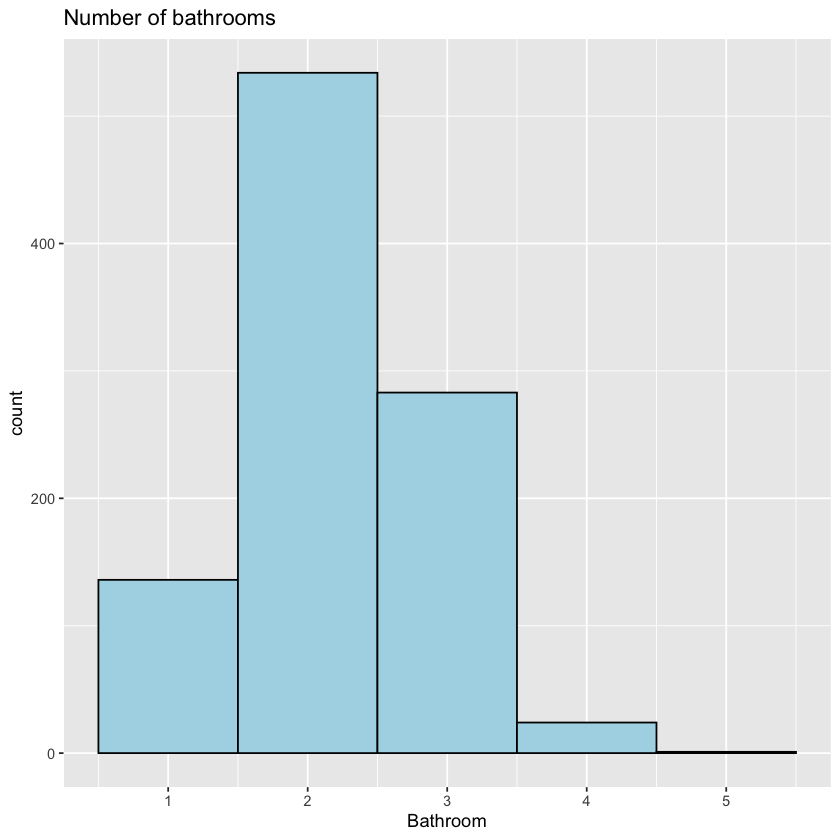

In [41]:
ggplot(clean["Bathroom"], aes(x = Bathroom)) + 
  geom_histogram(fill = "lightblue", color = "black",binwidth=1) + 
  ggtitle("Number of bathrooms")

#### Box Plot

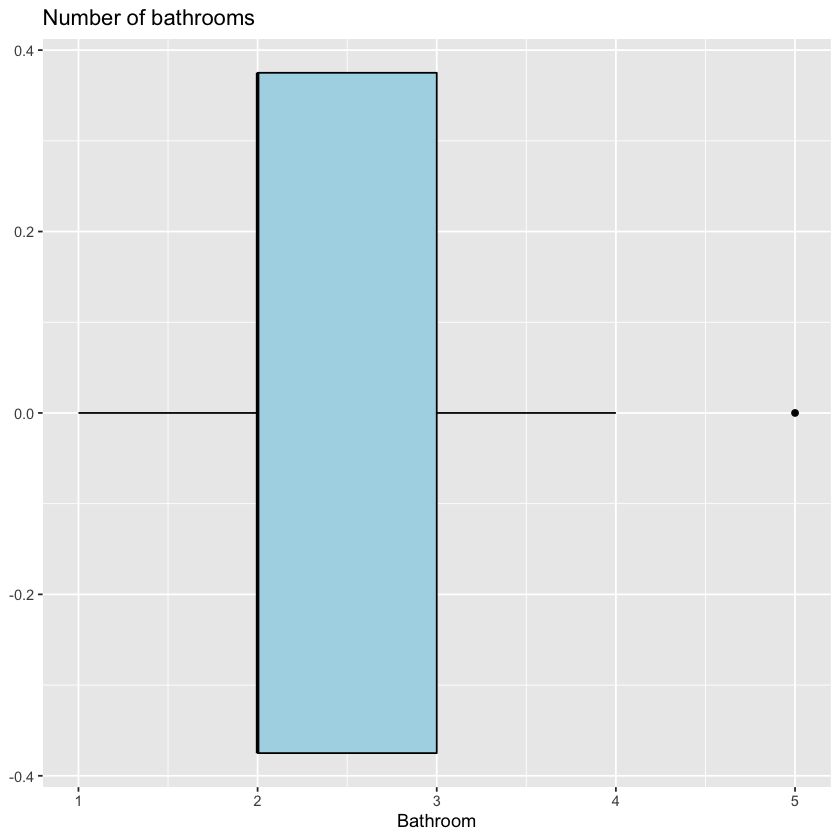

In [42]:
ggplot(clean["Bathroom"], aes(x = Bathroom)) + 
  geom_boxplot(fill = "lightblue", color = "black") + 
  ggtitle("Number of bathrooms")

#### Wartość średnia

In [43]:
round(mean(clean$Bathroom),digits=3)

[1] 2.202

#### Wariancja

In [44]:
round(var(clean$Bathroom),digits=3)

[1] 0.495

#### Odchylenie standardowe

In [45]:
round(sd(clean$Bathroom),digits=3)

[1] 0.704

#### Mediana

In [46]:
round(median(clean$Bathroom))

[1] 2

#### Zakres wartości

In [47]:
range(clean$Bathroom)

[1] 1 5

#### Kwantyle

In [48]:
quantile(clean$Bathroom)

0%  25%  50%  75% 100% 
   1    2    2    3    5

#### Skośność

In [49]:
skewness(clean$Bathroom)

[1] 0.1876507

Rozkład jest prawo skośny.

#### Wyostrzenie

In [50]:
kurtosis(clean$Bathroom)

[1] -0.03438296

Rozkład jest leptokurtyczny, inaczej wysmukły.

#### Przedział ufności średniej (95%)

In [51]:
size <- nrow(clean["Bathroom"])
sd <- sd(clean$Bathroom)
round(MeanCI(clean$Bathroom, sd = sd, conf.level = 0.95),digits = 4)

mean lwr.ci upr.ci 
2.2025 2.1583 2.2466

### 3.1.5 Parking 

Wartości zmiennej pochodzą z rozkładu dyskretnego więc nie będziemy wykonywać<br> testu na rozkład normalny, ani rysowć wykresu Q-Q plot.

#### Histogram

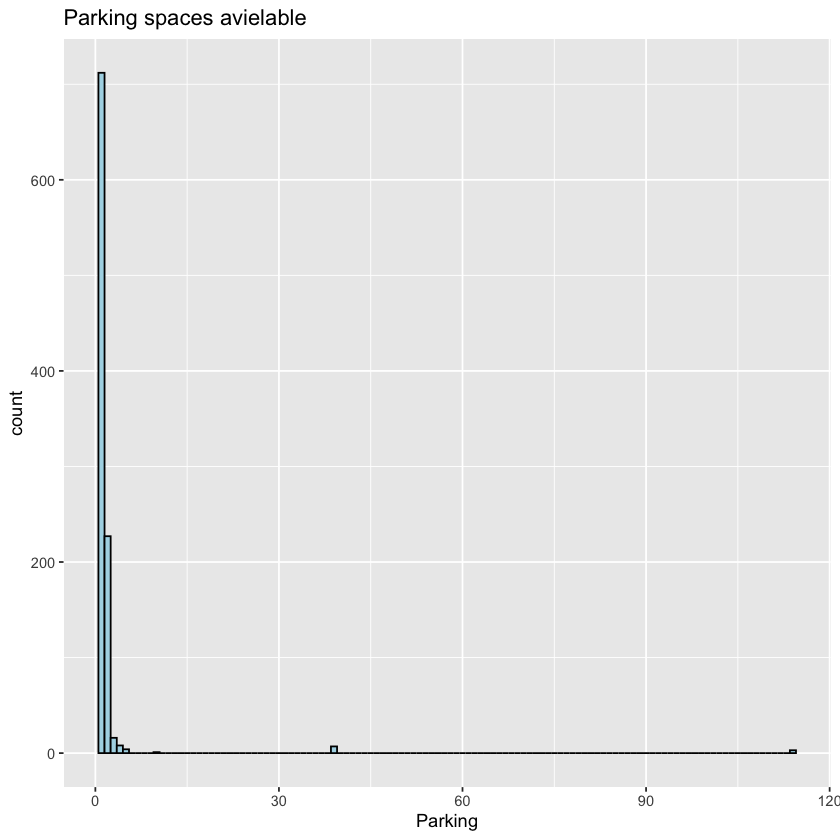

In [52]:
ggplot(clean["Parking"], aes(x = Parking)) + 
  geom_histogram(fill = "lightblue", color = "black",binwidth=1) + 
  ggtitle("Parking spaces avielable")

#### Box Plot

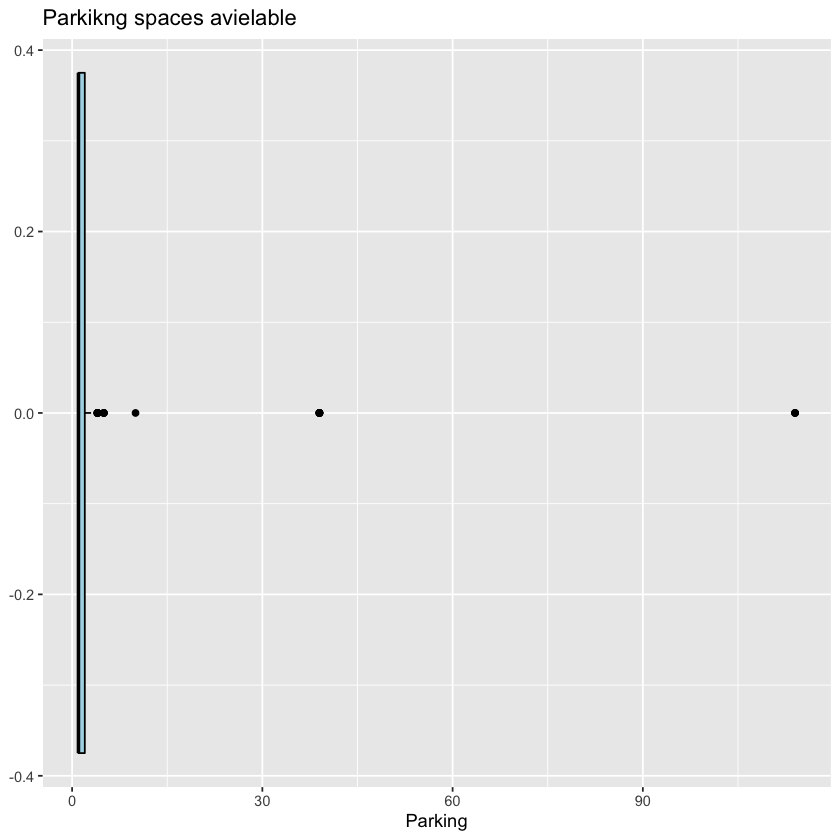

In [53]:
ggplot(clean["Parking"], aes(x = Parking)) + 
  geom_boxplot(fill = "lightblue", color = "black") + 
  ggtitle("Parkikng spaces avielable")

Z obu wykresów wynika, że pozostały wartości odstające, wynika to z faktu kilku mieszkań<br>  w tym samym miejscu współdzielących duże parkingi, jednak nie powinno to znacząco zaburzyć dalszych wyliczeń.

#### Wartość średnia

In [54]:
round(mean(clean$Parking),digits=3)

[1] 1.934

#### Wariancja

In [55]:
round(var(clean$Parking),digits=3)

[1] 49.202

#### Odchylenie standardowe

In [56]:
round(sd(clean$Parking),digits=3)

[1] 7.014

#### Mediana

In [57]:
round(median(clean$Parking),digits=3)

[1] 1

#### Zakres wartości

In [58]:
range(clean$Parking)

[1]   1 114

#### Kwantyle

In [59]:
quantile(clean$Price)

0%     25%     50%     75%    100% 
  54000  249480  567000  945000 1836000

#### Skośność

In [60]:
skewness(clean$Parking)

[1] 13.56583

Rozkład zmiennej Parking jest zdecydowanie prawo-skośny

#### Wyostrzenie

In [61]:
kurtosis(clean$Parking)

[1] 202.4376

Rozkład jest leptokurtyczny

#### T przedział ufności (95%)

In [62]:
size <- nrow(clean["Parking"])
sd <- sd(clean$Parking)
round(MeanCI(clean$Parking, sd = sd, conf.level = 0.95),digits = 4)

mean lwr.ci upr.ci 
1.9335 1.4939 2.3732

### 3.1.6 Per_SqM 

#### Histogram

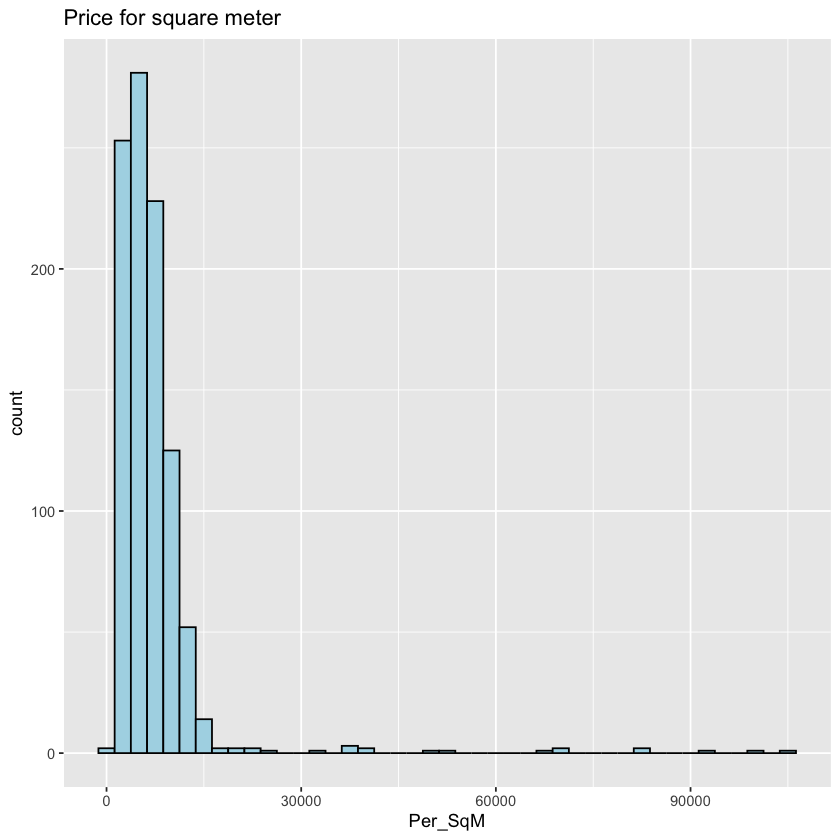

In [63]:
ggplot(clean["Per_SqM"], aes(x = Per_SqM)) + 
  geom_histogram(fill = "lightblue", color = "black",binwidth=2500) + 
  ggtitle("Price for square meter")

Z histogramu zmiennej wynika, że rozkład jest prawo-skośny.

#### Box Plot

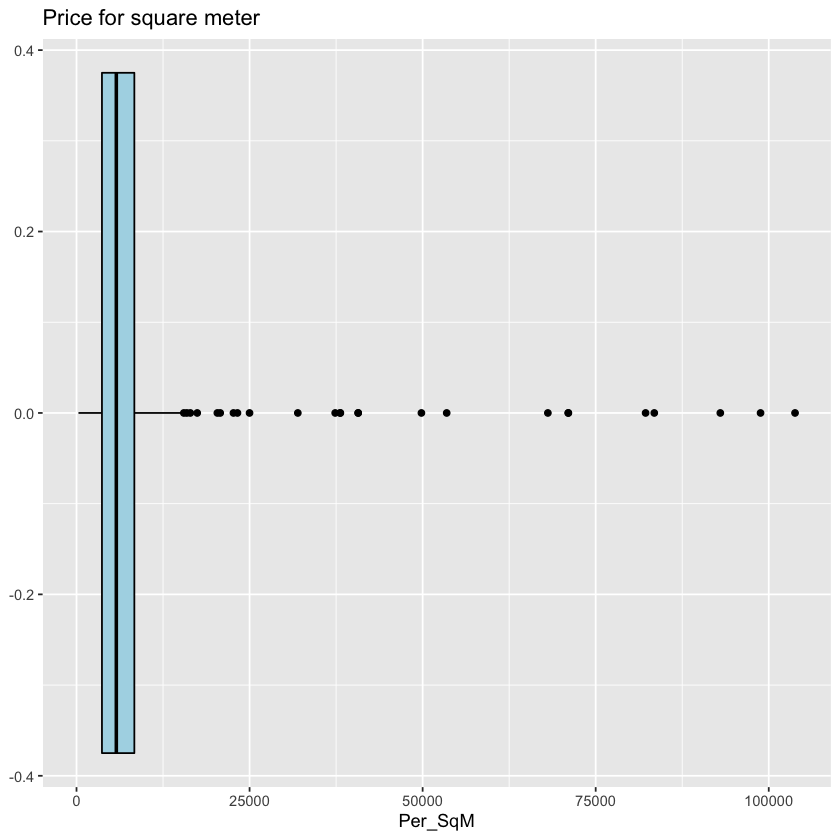

In [64]:
ggplot(clean["Per_SqM"], aes(x = Per_SqM)) + 
  geom_boxplot(fill = "lightblue", color = "black") + 
  ggtitle("Price for square meter")

Na wykresie box plot widoczne są wartości odstające jednakże, nie będziemy się ich pozbywać,<br>  ponieważ jest to jedynie sztucznie stworzona zmienna zależna od dwóch innych.

#### Q-Q plot

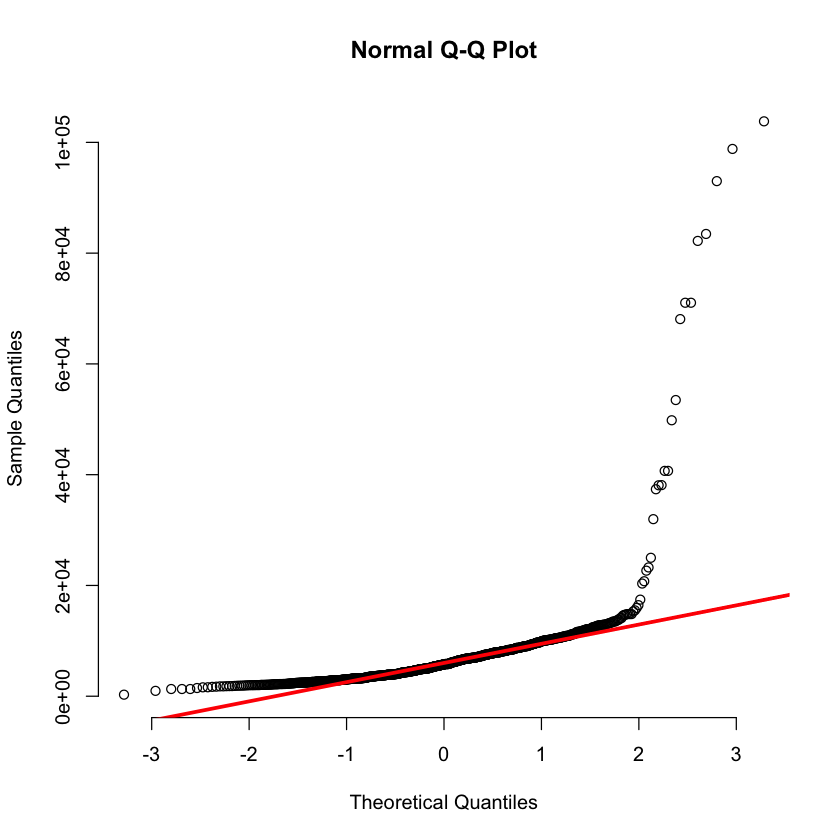

In [65]:
qqnorm(clean$Per_SqM, pch = 1, col = "black", frame = FALSE)
qqline(clean$Per_SqM, col = "red", lwd = 3)

#### Wartość średnia

In [66]:
round(mean(clean$Per_SqM),digits=4)

[1] 7179.869

#### Wariancja

In [67]:
round(var(clean$Per_SqM),digits=4)

[1] 71051502

#### Odchylenie standardowe

In [68]:
round(sd(clean$Per_SqM),digits=4)

[1] 8429.205

#### Mediana

In [69]:
round(median(clean$Per_SqM),digits=4)

[1] 5750.119

#### Zakres wartości

In [70]:
range(clean$Per_SqM)

[1]    279.8022 103798.2470

#### Kwantyle

In [71]:
quantile(clean$Per_SqM)

0%         25%         50%         75%        100% 
   279.8022   3673.7295   5750.1186   8354.4797 103798.2470

#### Skośność

In [72]:
skewness(clean$Per_SqM)

[1] 7.30801

Tak jak wcześniej zostało założone, rozkład jest prawo skośny.

#### Wyostrzenie

In [73]:
kurtosis(clean$Per_SqM)

[1] 65.55669

Rozkład jest leptokurtyczny.

#### Test na rozkład normalny

In [74]:
shapiro.test(clean$Per_SqM)


	Shapiro-Wilk normality test

data:  clean$Per_SqM
W = 0.40415, p-value < 2.2e-16


Dane nie pochodzą z rozkładu normalnego

#### Przedział ufności średniej (95%)

In [75]:
size <- nrow(clean["Per_SqM"])
sd <- sd(clean$Per_SqM)
round(MeanCI(clean$Per_SqM, sd = sd, conf.level = 0.95),digits = 0)

mean lwr.ci upr.ci 
  7180   6652   7708

## 3.2 Zależności pomiędzy zmiennymi
### 3.2.1 Wpływ powierzchni mieszkania na cenę.

####  Wykres punktowy zależności ceny od powierzchni mieszkania
dodatkowo została zastosowania linia najlepszego dopasowania dla lepszego zobrazowania rozkładu

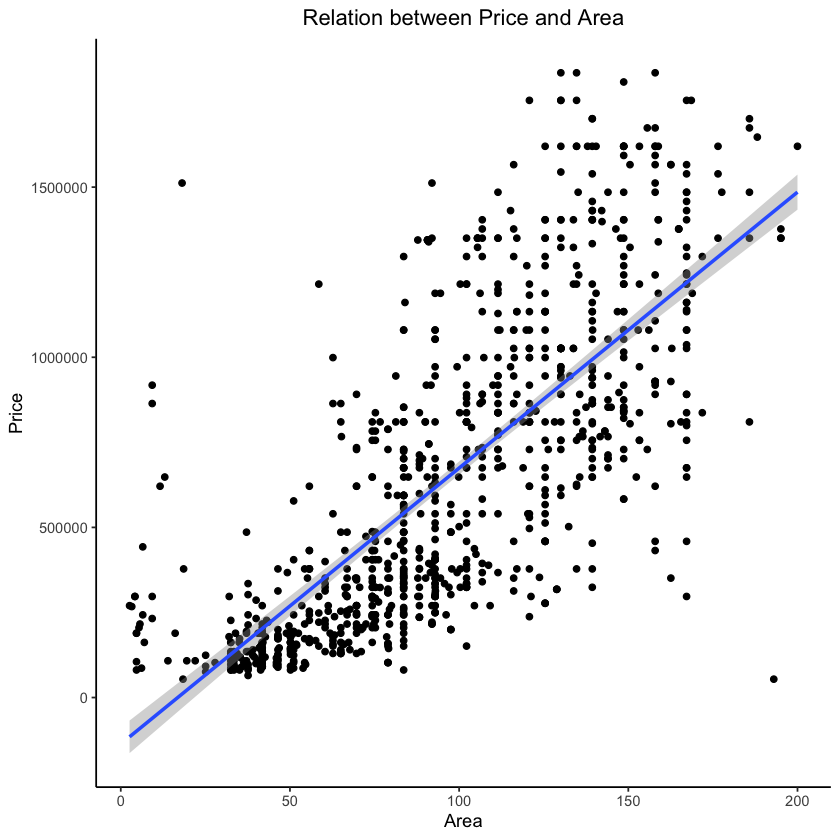

In [76]:
ggplot(data=clean,mapping = aes(x = Area, y= Price))+geom_point()+
  theme_classic() +
  ggtitle("Relation between Price and Area") +
  theme(plot.title = element_text(hjust = 0.5)) +
  xlab("Area") +
  ylab("Price")+ geom_smooth(formula=y ~ x,method="lm")


Pomimo wyraźnego rozproszenia punktów wobec linii, widać ich większe skupienie w jej pobliżu.

#### Kowariancja 

In [77]:
cov(clean$Area,clean$Price)

[1] 13819426

Wartość jest większa od 0 więc zmienne są ze sobą związane. 

#### Korelacja

In [78]:
cor(clean$Area,clean$Price)

[1] 0.7387042

Wartości korelacji należą do przedziału od -1 do 1. <br>Korelacja o wartości 0.717 oznacza bardzo silne powiązanie zmiennych.<br>  Teraz możemy formalnie stwierdzić, że im większa powierzchnia mieszkania tym większa cena, co potwierdza naturalne przypuszczenia.

### 3.2.2 Wpływ ilości sypialni na cenę.

Wykresy danych z dystrybucji dyskretnej w połczeniu ze zmienną lową price nie pozwalają na zbyt wiele wniosków,<br>  więc ograniczymy się do analizowania kowariancji i korelacji pozostałych zmiennych

#### Kowariancja

In [79]:
cov(clean$BHK,clean$Price)

[1] 167484.9

Wartość jest większa od 0 więc zmienne są ze sobą związane.

#### Korelacja

In [80]:
cor(clean$BHK,clean$Price)

[1] 0.4907507

Uzyskana wartość korelacji mówi nam, że ilość sypialni nie ma tak dużego znaczenia jak powierzchnia. Mimo to relacja pomiędzy Price, a BHK jest silna.

### 3.2.3 Wpływ ilośći łazienek na cenę.

####  Kowariancja

In [81]:
cov(clean$Bathroom,clean$Price)

[1] 194081.9

Wartość większa od zera wskazuję na powiązanie tych dwóch zmiennych.

#### Korelacja 

In [82]:
cor(clean$Bathroom,clean$Price)

[1] 0.6085225

Wyskość wartość korelacji pomiędzy zmiennymi Bathroom i Price oznacza większy wpływ na cenę dodatkowej łazienki, <br> niż sypialni (oczywiście tylko w teorii).

#### 3.2.4 Wpływ ilości miejsc parkingowych na cenę mieszkania.

#### Kowariancja

In [83]:
cov(clean$Parking,clean$Price)

[1] -140859.6

Zaskakującym wnioskiem jest to, że ilość miejsc parkingowych jest odwrotnie proporcjonalna do ceny.<br>  Może na to wskazywać fakt, że w mieszkaniach (w bloku) liczone są wszystkie dostępne miejsca parkingowe.

#### Korelacja

In [84]:
cor(clean$Parking,clean$Price)

[1] -0.04431207

Wartość jest bliska zeru, co oznacza bardzo słabą relację.

### 3.3 Regresja Liniowa

#### Ustawiamy seed dla powtarzalności naszego modelu

In [85]:
set.seed(80)

#### Rozdzielamy nasze dane na zbiór treningowy i testowy.

In [86]:
clean <- subset(clean,select = -c(Per_SqM))
training_set <- clean[1:720,]
testing_set <- clean[720:843,]

#### Budujemy nasz model

In [87]:
Model <- train(Price ~ .,data=training_set, method = "lm",na.action = na.omit,
               preProcess=c("scale","center"), trControl = trainControl(method="none"))

#### Trenujemy i testujemy nasz model

In [88]:
Model.training <- predict(Model,training_set)
Model.testing <- predict(Model,testing_set)

#### Wykres punktowy dla części treningowej naszego modelu

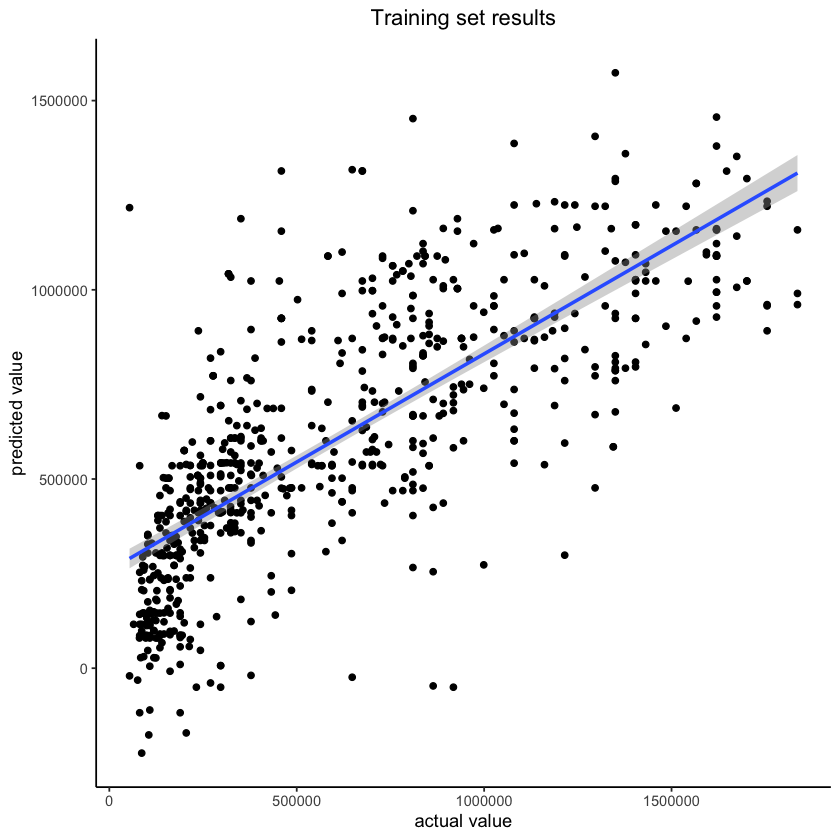

In [89]:
ggplot(mapping = aes(x = training_set$Price, y= Model.training))+geom_point()+
  theme_classic() +
  ggtitle("Training set results") +
  theme(plot.title = element_text(hjust = 0.5)) +
  xlab("actual value") +
  ylab("predicted value")+ geom_smooth(formula=y ~ x,method="lm")



#### Wykres punktowy dla części testowej naszego modelu.

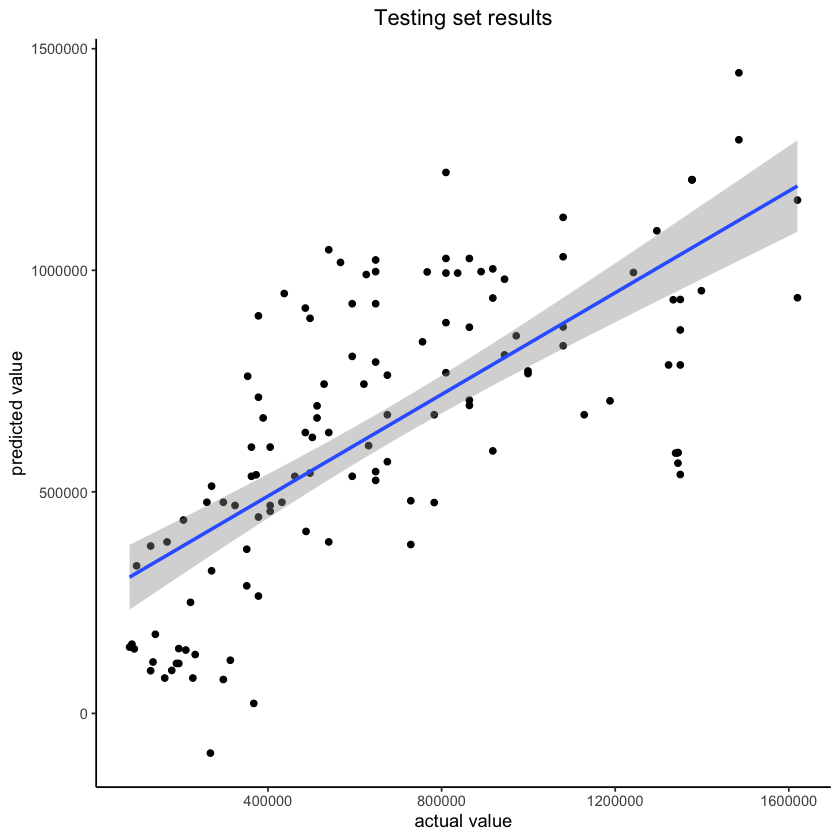

In [90]:
ggplot(mapping = aes(x = testing_set$Price, y= Model.testing))+geom_point()+
  theme_classic() +
  ggtitle("Testing set results") +
  theme(plot.title = element_text(hjust = 0.5)) +
  xlab("actual value") +
  ylab("predicted value")+ geom_smooth(formula=y ~ x,method="lm")

#### Wartości jakie przyjął nasz model.

In [91]:
summary(Model)


Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
     Min       1Q   Median       3Q      Max 
-1163093  -196985   -36662   175493   968205 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   604768      11222  53.889  < 2e-16 ***
Area          299622      16744  17.894  < 2e-16 ***
BHK           -46353      17112  -2.709  0.00691 ** 
Bathroom      106817      17058   6.262 6.56e-10 ***
Parking        12600      11406   1.105  0.26966    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 301100 on 715 degrees of freedom
Multiple R-squared:  0.5716,	Adjusted R-squared:  0.5692 
F-statistic: 238.5 on 4 and 715 DF,  p-value: < 2.2e-16


Hipotezą zerową dla każdego ze współczynniów było H0:Bi=0, natomiast alternatywną H1:Bi!=0. W przypadku BHK oraz Parking nie mamy podstaw do odrzucenia hipotezy zerowej. Dla  Area oraz Bathroom odrzucamy hipotezę zerową na rzecz alternatywnej.

Zgodnie z założeniem, kluczową rolę w wycenie mieszkania odgrywa jego powierzchnia.<br>
Zbudowany przez nas model byłby dokładniejszy kiedy wprowadzilibyśmy więcej czynników, takich jak<br>  odległości od popularnych miejsc czy średnia pensja lokatorów.<br>  Oczywistym faktem jest, że nasz model byłby dużo lepszy gdybyśmy dostarczyli więcej danych do trenowania. Zaskakującym wnioskiem którego dostarcza nasz model jest brak istotności liczby pokoi sypialnych w wycenie mieszkania.




## Wnioski

Dane pozyskane z wcześniej podanego źródła wyczyściliśmy, usuwając wartości odstające, zmieniając jednostki<br>  oraz usuwając niepotrzebne do analizy kolumny.
<br>Dla istotnych kolumn przeprowadziliśmy analize danych oraz wykonaliśmy testy przynależności do rozkładu normalnego zmiennej,<br>  oprócz zmiennych o rozkładzie dyskretnym takich jak liczba sypialni.
<br>Z badania relacji ceny od poszczególnych zmiennych dowiedzieliśmy się, że najistotniejszym warunkiem jest powierzchnia mieszkania.<br>  Zaskakujący jest fakt, że ilość łazienek bardziej wpływa na cenę niż ilość sypialni.
<br>Na koniec zbudowaliśmy prosty model regresji liniowej potrafiący w pewnym stopniu przewidzieć cenę mieszkania.